# Tree Ring Analysis: Comparasion

Author: Johnny Esteves, University Of Michigan

### Description
Here we compare tree ring signal (second moments and astro. shift) with the flat field signal.

In [43]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import posixpath, datetime, sys
import cv2

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

#
from scipy.signal import butter, sosfilt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import os
import glob
import numpy as np
import fitsio as fits
import matplotlib.pyplot as plt


# Load Data

Retrieving files path from BUTLER.

In specific, for loading the results after the corrections made on the mixcoatl code by Alex I use the repo_path used `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml` and the collection `u/youtsumi/spot/AlexRecommendation`.


### Initialize the `spotgrid.py` code

In [45]:
import sys
sys.path.append('/gpfs/slac/kipac/fs1/u/esteves/codes/TreeRing/')
from spotgrid_butler import SpotgridCatalog

In [46]:
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'
itl = SpotgridCatalog(repo,
                      'u/asnyder/spot/itl_analysis',
                      'u/asnyder/spot/itl_calibration',sensor='ITL')

Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/itl_analysis
calib collection  : u/asnyder/spot/itl_calibration




In [47]:
itl.get_calibration_table()
itl.load_data()
itl.compute_statistics()
itl.compute_spotgrid()
itl.filter_spots()
itl.calibrate()

Found tmp/r02_s02_x_arr.npy
Found tmp/r02_s02_y_arr.npy
Found tmp/r02_s02_xx_arr.npy
Found tmp/r02_s02_xy_arr.npy
Found tmp/r02_s02_yy_arr.npy
Found tmp/r02_s02_dx_arr.npy
Found tmp/r02_s02_dy_arr.npy
Found tmp/r02_s02_dxx_arr.npy
Found tmp/r02_s02_dyy_arr.npy
Found tmp/r02_s02_dxy_arr.npy
Found tmp/r02_s02_instFlux_arr.npy
Found tmp/r02_s02_instFluxErr_arr.npy
Found tmp/r02_s02_x_center_arr.npy
Found tmp/r02_s02_y_center_arr.npy
Found tmp/r02_s02_dFlux_arr.npy
Found tmp/r02_s02_dg1_arr.npy
Found tmp/r02_s02_dg2_arr.npy
Loading data for ITL tmp/r02_s02.
Computing statistics for ITL tmp/r02_s02.
Computing filter spots for ITL tmp/r02_s02.


## Polar Transformation

In [48]:
from tree_ring_helper import *

In [49]:
#help(tree_ring_tools)

In [50]:
#centers = [[4320,-280],[-156,-280],[4320,4180],[-156,4180]]
#centers = [[-310, 4086.36],[-156,-280],[4320,4180],[4439.24, -434.62]]
centers = [[-335.49, 4095.84],[-156,-280],[4320,4180],[4627.47, -630.89]]

sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

In [51]:
def proj_to_polar_coord(t,vx,vy):
    vr = np.cos(t)*vx + np.sin(t)*vy
    vt = -np.sin(t)*vx+ np.cos(t)*vy
    return vr, vt

def proj_to_polar_coord_spin2(t,vx,vy):
    vr = np.cos(2*t)*vx + np.sin(2*t)*vy
    vt = np.sin(2*t)*vx - np.cos(2*t)*vy
    return vr, vt

def trasnform_to_polar_coord(x,y,x0=0.,y0=0.,deg=False):
    r = np.hypot((x-x0),(y-y0))
    t = np.arctan2((y-y0),(x-x0))
    
    if deg: t *= (180 / np.pi)
    return r,t

In [52]:
xc,yc = centers[0]
r, t = trasnform_to_polar_coord(itl.xfltr_flat,itl.yfltr_flat, x0=xc, y0=yc)

dr,dt= proj_to_polar_coord(t,itl.dX,itl.dY)
dgr,dgt= proj_to_polar_coord_spin2(t,itl.dg1,itl.dg2)

itl.dR = dr
itl.dt = dt

itl.dgr= dgr
itl.dgt= dgt

In [53]:
sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

def generate_image(self,var,MAX=0.07,fradius=140,sensor='e2v'):
    
    nanmask = np.isfinite(self.deltaXX) #masks all the NaN entries created when a catalog didn't have 2401 entries
    xxfltr_flat = self.xxfltr[nanmask].flatten()
    yyfltr_flat = self.yyfltr[nanmask].flatten()

    dmap = {'dT':self.dT/(xxfltr_flat+yyfltr_flat),'dXX':self.dXX/(xxfltr_flat),'dYY':self.dYY/(yyfltr_flat),'dXY':self.dXY,
            'dX':self.dX,'dY':self.dY,'dg1':self.dg1,'dg2':self.dg2,'dF':self.deltaF,
            'dr':self.dR,'dtheta':self.dt,'dgr':self.dgr,'dgt':self.dgt}
    
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(self.xfltr_flat, self.yfltr_flat, dmap[var], 'mean',
                                                          range=sensor_lims[sensor], bins=bins)
                                                          #mean is significantly faster calculation
    
    ## cut borders
    mask    = mask_borders(self,x_edge,y_edge,dT_mean,MAX=MAX,fradius=fradius)
    
    ## sensor max limits
    xmax = sensor_lims[self.sensor][0][1]
    ymax = sensor_lims[self.sensor][1][1]
    
    ## resize image
    resized     = cv2.resize(dT_mean.T,(xmax,ymax), interpolation = cv2.INTER_AREA)
    resized_cut = cv2.resize(mask.T   ,(xmax,ymax), interpolation = cv2.INTER_AREA)
    
    return dT_mean,resized,resized_cut

## Visualize the dataset

In [54]:
## choose the sensor

self = itl

title  = 'ITL: R02 S02'
ylabel = 'dev. from the mean [pixel]'

In [55]:
#e2v=0
#itl=0

# Figure 1 - Astrometric Shift, Second Moments and Ellipticity Maps

In [56]:
_,_,dr_img =  generate_image(self,'dr' ,fradius=150)
_,_,dt_img =  generate_image(self,'dT' ,fradius=150)
_,_,dg_img =  generate_image(self,'dgr',fradius=150)


dr_img1 = apply_filter(dr_img, 250, power=4)
dt_img1 = apply_filter(dt_img, 250, power=4)
dg_img1 = apply_filter(dg_img, 250, power=4)

In [57]:
_,_,dxx_img =  generate_image(self,'dXX' ,fradius=150)
_,_,dyy_img =  generate_image(self,'dYY' ,fradius=150)

_,_,dx_img =  generate_image(self,'dX' ,fradius=150)
_,_,dy_img =  generate_image(self,'dY' ,fradius=150)

_,_,dg1_img =  generate_image(self,'dg1' ,fradius=150)
_,_,dg2_img =  generate_image(self,'dg2' ,fradius=150)

dxx_img1 = apply_filter(dxx_img, 250, power=4)
dyy_img1 = apply_filter(dyy_img, 250, power=4)

dx_img1  = apply_filter(dx_img, 250, power=4)
dy_img1  = apply_filter(dy_img, 250, power=4)

dg1_img1 = apply_filter(dg1_img, 250, power=4)
dg2_img1 = apply_filter(dg2_img, 250, power=4)

In [58]:
def imshow(image,axes,title='',show_colorbar=False,levels=[-0.015,0.015]):
    im0 = axes.imshow(image,origin='lower',vmin=levels[0],vmax=levels[1], cmap='viridis')
    axes.set_xlabel('X position [pixels]', fontsize=15)
    axes.set_ylabel('Y position [pixels]', fontsize=15)
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
    axes.set_aspect('equal')
    axes.set_title(title)
    if show_colorbar: return im0

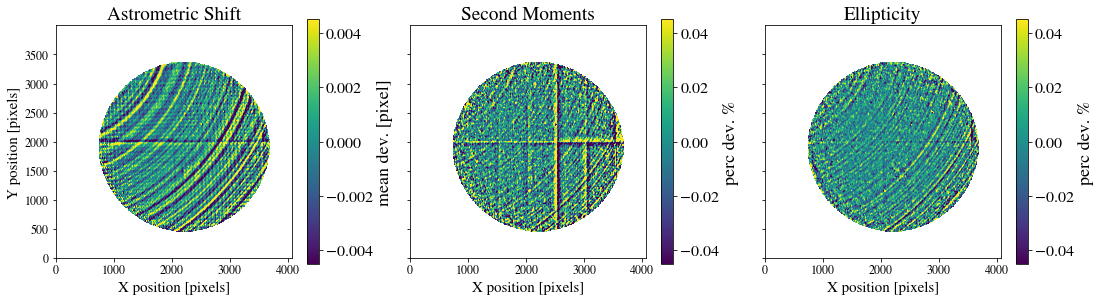

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey='all')

levels = np.array([-0.0045,0.0045])
im1 = imshow(dr_img1 ,axes[0],title='Astrometric Shift',levels=levels*1., show_colorbar=True)
im2 = imshow(100.*dt_img1 ,axes[1],title='Second Moments'   ,levels=levels*10., show_colorbar=True)
im3 = imshow(100.*dg_img1 ,axes[2],title='Ellipticity'      ,levels=levels*10., show_colorbar=True)

fig.colorbar(im1,ax=axes[0] ,shrink=0.75).set_label(r'mean dev. [pixel]', fontsize=18)
fig.colorbar(im2,ax=axes[1] ,shrink=0.75).set_label(r'perc dev. %', fontsize=18)
fig.colorbar(im3,ax=axes[2] ,shrink=0.75).set_label(r'perc dev. %', fontsize=18)

for i in range(1,3):
    axes[i].set_ylabel('')

fig.subplots_adjust(wspace=0.20)
#fig.savefig('figures/fig_1_map_astroShift_secMoments_ellipticity.pdf', dpi=240, format='pdf', bbox_inches='tight')
# plt.suptitle(title)
#plt.clf()

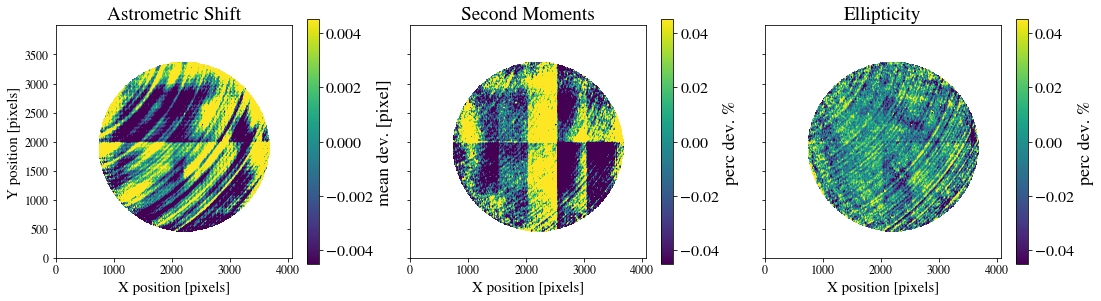

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey='all')

levels = np.array([-0.0045,0.0045])
im1 = imshow(dr_img, axes[0], title='Astrometric Shift',levels=levels*1., show_colorbar=True)
im2 = imshow(100.*dt_img, axes[1], title='Second Moments'   ,levels=levels*10., show_colorbar=True)
im3 = imshow(100.*dg_img, axes[2], title='Ellipticity'      ,levels=levels*10., show_colorbar=True)

fig.colorbar(im1,ax=axes[0] ,shrink=0.75).set_label(r'mean dev. [pixel]', fontsize=18)
fig.colorbar(im2,ax=axes[1] ,shrink=0.75).set_label(r'perc dev. %', fontsize=18)
fig.colorbar(im3,ax=axes[2] ,shrink=0.75).set_label(r'perc dev. %', fontsize=18)

for i in range(1,3):
    axes[i].set_ylabel('')

fig.subplots_adjust(wspace=0.20)
#fig.savefig('figures/fig_1_map_astroShift_secMoments_ellipticity.pdf', dpi=240, format='pdf', bbox_inches='tight')
# plt.suptitle(title)
#plt.clf()

# Figure 2 - Signal Profiles

In [61]:
image = dt_img1

In [62]:
# Pixel coordinate grid
y,x   = np.mgrid[0:image.shape[0] , 0:image.shape[1]]
y,x   = np.mgrid[0:image.shape[0] , 0:image.shape[1]]

def get_direction(direction,x0=0.,y0=0.):
    if direction=='r':
        res = np.hypot(x-x0, y-y0)
    elif direction=='y':
        res = y
    else:
        res = x
    return res

def get_stats(x,y,nbins=10):
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    
    n = np.where(n<1.,np.nan,n)
    
    bins = (_[1:] + _[:-1])/2
    mean = sy / n
    
    std = np.sqrt(sy2/n - mean*mean) / np.sqrt(n)
    return bins, mean, std

def make_profile(diff, direction='x', mask=None, nbins=11, x0=0., y0=0.):
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    
    x    = get_direction(direction,x0,y0)
    xvar = x[idx].flatten()
    cvar = diff[idx].flatten()
    xb,cm,ce = get_stats(xvar,cvar,nbins=nbins)
    return xb,cm,ce

In [63]:
def plot_profile(x,y,yerr,bins,ax=None):
    if ax is None: ax = plt.axes()
    xerr = np.diff(bins)/2.
    ax.errorbar(x,y,yerr=yerr,xerr=xerr)

## Signal Profiles

Characterize the singal characteristics on second moments, ellipticity and astrometric shift. 

In [64]:
lines = np.linspace(np.min(x),np.max(x),9)[2:-1]

In [65]:
lines

array([1017.75 , 1526.625, 2035.5  , 2544.375, 3053.25 , 3562.125])

In [66]:
rad_bins = np.linspace(0.,5000.,400)

In [27]:
def plot_signal_profile_across(images,labels,ax1=None,scale=1.,xlabel=True,mask=None):
    if ax1 is None: ax1 = plt.axes()
    
    for i,image in enumerate(images):
        out = make_profile(image, direction='x', mask=mask,x0=xc,y0=yc,nbins=rad_bins)
        std = scale*np.nanstd(out[1])
        ax1.errorbar(out[0], scale*out[1],yerr=scale*out[2],label=labels[i])
        
        if i==0: 
            ax1.set_ylim(-4.*std,4.*std)
            print('peak: %.5f'%np.nanmax(np.abs(out[1][np.abs(out[0]-2000.)<1000.])))

    for li in lines:
        ax1.axvline(li,color='grey',ls='--',lw=3,alpha=0.4)
    
    ax1.legend(fontsize=12,loc=2)
    if xlabel:
        ax1.set_xlabel('x [pixels]',fontsize=18)

peak: 0.00110
peak: 0.00022
peak: 0.00376


Text(0.5, 1.0, 'Astrometric Shift')

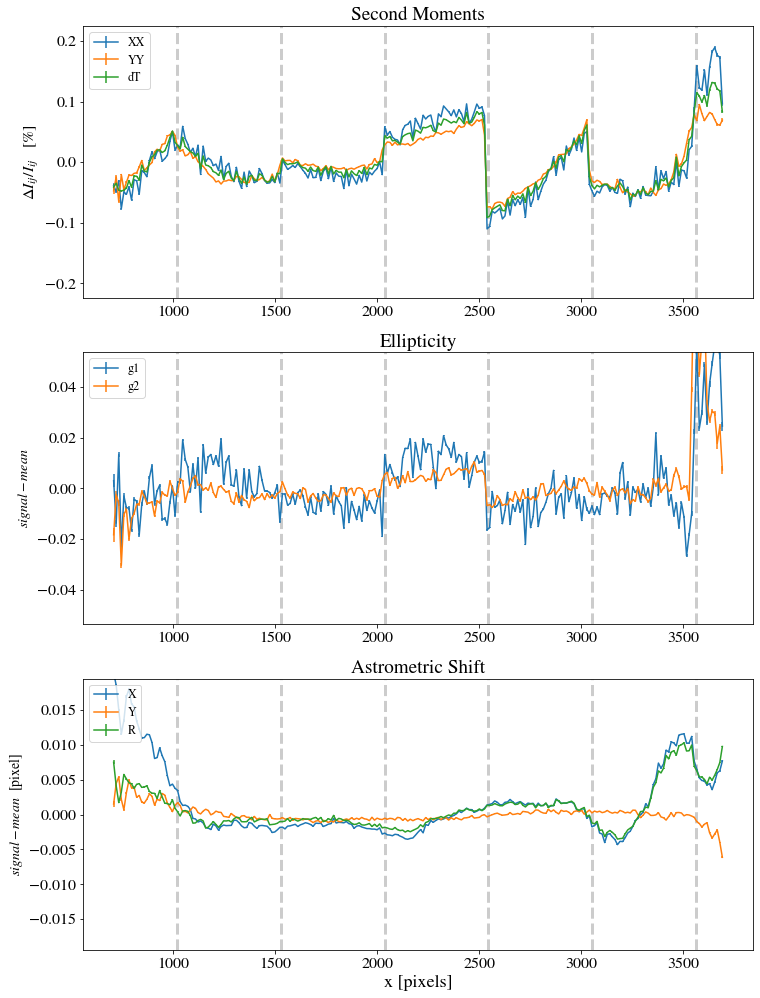

In [28]:
fig, axs = plt.subplots(3,1,figsize=(12,3*5+2))

labels = ['XX','YY','dT']
images = [dxx_img,dyy_img,dt_img]
plot_signal_profile_across(images,labels,ax1=axs[0],scale=100.,xlabel=False)
axs[0].set_ylabel(r'$\Delta I_{ij} / I_{ij}$   [%]')
axs[0].set_title('Second Moments')

labels = ['g1','g2']
images = [dg1_img,dg2_img]
plot_signal_profile_across(images,labels,ax1=axs[1],scale=100.,xlabel=False)
axs[1].set_ylabel(r'$signal-mean$', fontsize=14)
axs[1].set_title('Ellipticity')

labels = ['X','Y','R']
images = [dx_img,dy_img,dr_img]
plot_signal_profile_across(images,labels,ax1=axs[2],scale=1.,xlabel=True)
axs[2].set_ylabel(r'$signal-mean$  [pixel]', fontsize=14)
axs[2].set_title('Astrometric Shift')

#fig.savefig('figures/fig_2_signal_profile_vs_x.pdf', dpi=240, format='pdf', bbox_inches='tight')

In [29]:
# lines = np.linspace(np.min(x),np.max(x),9)#[1:-1]

peak: 0.09565
peak: 0.18128
peak: 0.12019
peak: 0.12765
peak: 0.19802
peak: 0.13272
peak: 0.16139
peak: 0.16823


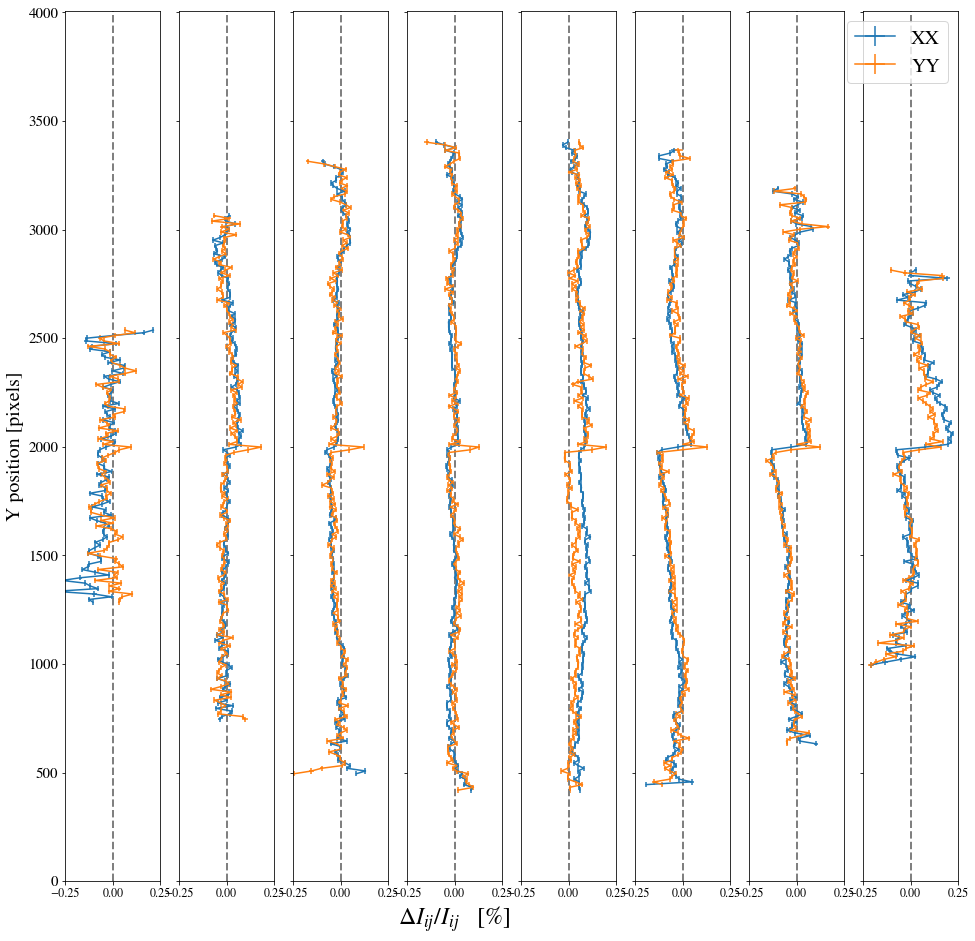

In [70]:
fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))

#xbins = np.percentile(xmed[~np.isnan(ymean1)],np.linspace(0,100,9))
xbins = np.arange(420,4096,424)

for i in range(8):
    xmask = np.logical_not((x>xbins[i])&(x<=xbins[i+1]))
    #xmask = np.logical_not((x>lines[i])&(x<=lines[i+1]))
    ymed, ymean1, yerr1 = make_profile(100.*dxx_img  , direction='y', mask=xmask, x0=xc,y0=yc, nbins=rad_bins)
    ymed, ymean2, yerr2 = make_profile(100.*dyy_img  , direction='y', mask=xmask, x0=xc,y0=yc, nbins=rad_bins)
    
    axes2[i].axvline(0.,ls='--',color='grey',lw=2)
    axes2[i].errorbar(ymean1, ymed, yerr=np.diff(rad_bins), xerr=yerr1, label='XX')
    axes2[i].errorbar(ymean2, ymed, yerr=np.diff(rad_bins), xerr=yerr2, label='YY')
    
    axes2[i].set_ylim((0, 4004))
    
    w, = np.where(np.abs(ymed-2000.)<250.)
    pi = np.nanmax(np.abs(ymean2[w]))
    print('peak: %.5f'%pi)
    li=0.25
    axes2[i].set_xlim(-li,li)

    #axes2[i].set_xlim(50.*levels[0],50.*levels[1])
    axes2[i].tick_params(axis='y', labelleft=False)
    axes2[i].tick_params(axis='x', labelsize=12)
    
axes2[0].tick_params(axis='y', labelsize=15, labelleft=True)
axes2[0].set_ylabel('Y position [pixels]', fontsize=20)
# axes2[3].set_title(r'$\Delta$2nd moment vs. Y', fontsize=20)
axes2[3].set_xlabel(r'$\Delta I_{ij} / I_{ij}$   [%]', fontsize=24)
axes2[7].legend(loc='upper right', fontsize=20)

#fig2.savefig('figures/fig_3a_secMoments_profile_across_x.pdf', dpi=240, format='pdf', bbox_inches='tight')

<ipython-input-22-ab28ec09c952>:24: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean) / np.sqrt(n)


peak: 0.01334
peak: 0.00958
peak: 0.00976
peak: 0.00902
peak: 0.01093
peak: 0.01115
peak: 0.00868
peak: 0.01220


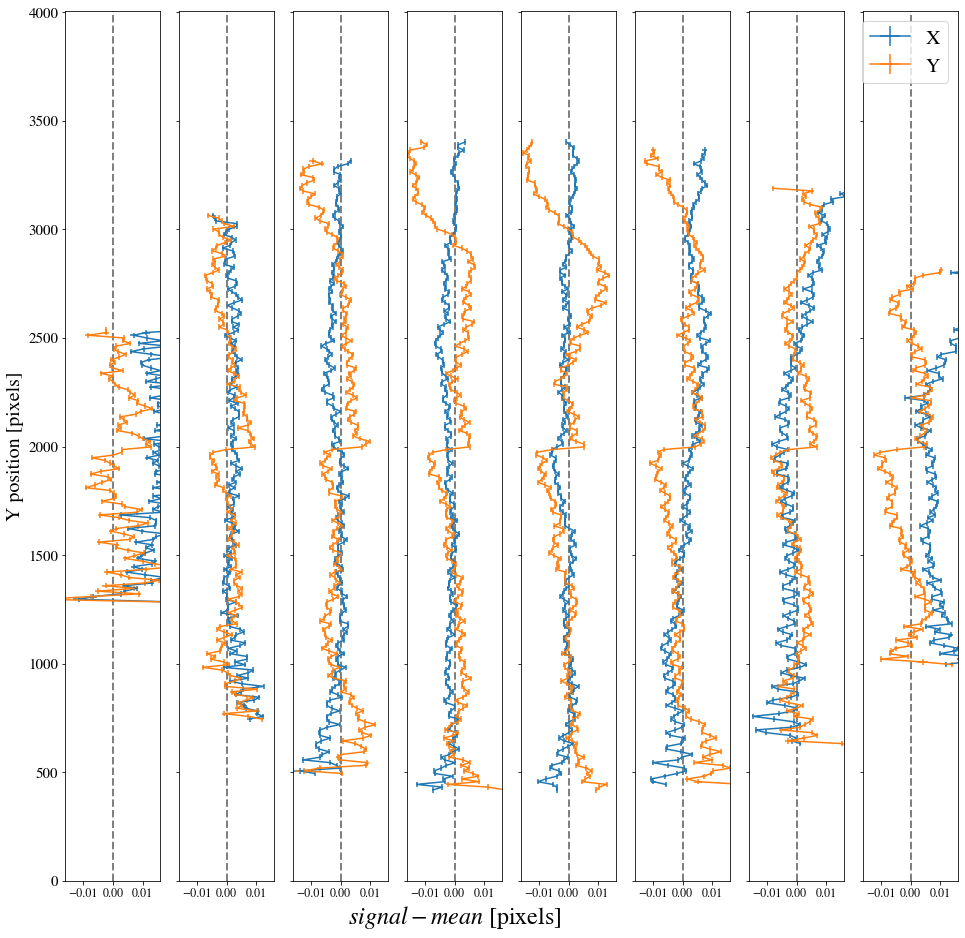

In [31]:
fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))

#xbins = np.percentile(xmed[~np.isnan(ymean1)],np.linspace(0,100,9))
xbins = np.arange(420,4096,424)

for i in range(8):
    xmask = np.logical_not((x>xbins[i])&(x<=xbins[i+1]))
    ymed, ymean1, yerr1 = make_profile(dx_img, direction='y', mask=xmask, x0=xc,y0=yc, nbins=rad_bins)
    ymed, ymean2, yerr2 = make_profile(dy_img, direction='y', mask=xmask, x0=xc,y0=yc, nbins=rad_bins)
    
    axes2[i].axvline(0.,ls='--',color='grey',lw=2)
    axes2[i].errorbar(ymean1, ymed, yerr=np.diff(rad_bins), xerr=yerr1, label='X')
    axes2[i].errorbar(ymean2, ymed, yerr=np.diff(rad_bins), xerr=yerr2, label='Y')
    
    axes2[i].set_ylim((0, 4004))
    w, = np.where(np.abs(ymed-2000.)<250.)
    pi = np.nanmax(np.abs(ymean2[w]))
    print('peak: %.5f'%pi)
    if i == 0: li = 1.2*pi
    axes2[i].set_xlim(-li,li)

    #axes2[i].set_xlim(9.*levels[0],9.*levels[1])
    axes2[i].tick_params(axis='y', labelleft=False)
    axes2[i].tick_params(axis='x', labelsize=12)
    
axes2[0].tick_params(axis='y', labelsize=15, labelleft=True)
axes2[0].set_ylabel('Y position [pixels]', fontsize=20)
# axes2[3].set_title(r'$\Delta$2nd moment vs. Y', fontsize=20)
axes2[3].set_xlabel(r'$signal-mean$ [pixels]', fontsize=24)
axes2[7].legend(loc='upper right', fontsize=20)
#fig2.savefig('figures/fig_3b_astroShift_profile_across_x.pdf', dpi=240, format='pdf', bbox_inches='tight')

<ipython-input-62-ab28ec09c952>:24: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean) / np.sqrt(n)


peak: 0.05799
peak: 0.05836
peak: 0.07112
peak: 0.06524
peak: 0.05235
peak: 0.07064
peak: 0.07059
peak: 0.07120


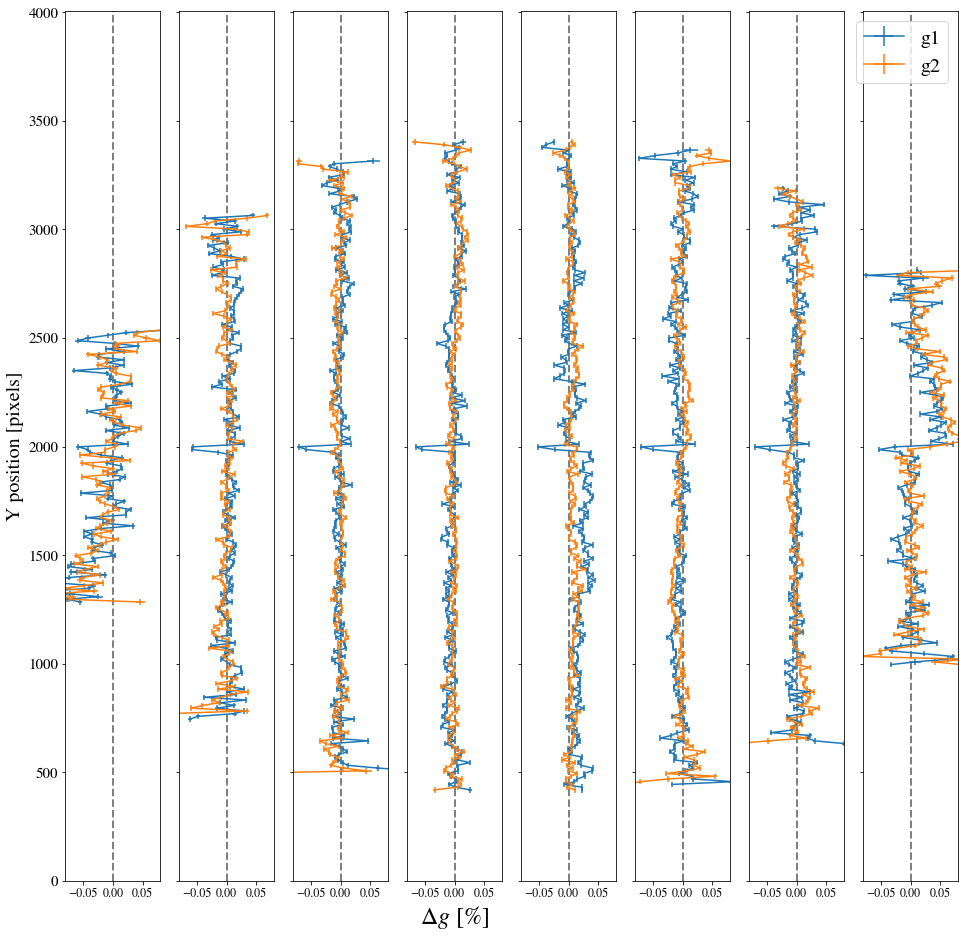

In [71]:
fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))

#xbins = np.percentile(xmed[~np.isnan(ymean1)],np.linspace(0,100,9))
xbins = np.arange(420,4096,424)

for i in range(8):
    xmask = np.logical_not((x>xbins[i])&(x<=xbins[i+1]))
    ymed, ymean1, yerr1 = make_profile(100.*dg1_img  , direction='y', mask=xmask, x0=xc,y0=yc, nbins=rad_bins)
    ymed, ymean2, yerr2 = make_profile(100.*dg2_img  , direction='y', mask=xmask, x0=xc,y0=yc, nbins=rad_bins)
    
    axes2[i].axvline(0.,ls='--',color='grey',lw=2)
    axes2[i].errorbar(ymean1, ymed, yerr=np.diff(rad_bins), xerr=yerr1, label='g1')
    axes2[i].errorbar(ymean2, ymed, yerr=np.diff(rad_bins), xerr=yerr2, label='g2')
    
    axes2[i].set_ylim((0, 4004))
    
    axes2[i].set_ylim((0, 4004))
    w, = np.where(np.abs(ymed-2000.)<250.)
    pi = np.nanmax(np.abs(ymean1[w]))
    print('peak: %.5f'%pi)
    #if i == 0: li = 1.02*pi
    li = 0.08
    axes2[i].set_xlim(-li,li)

    #axes2[i].set_xlim(50.*levels[0],50.*levels[1])
    axes2[i].tick_params(axis='y', labelleft=False)
    axes2[i].tick_params(axis='x', labelsize=12)
    
axes2[0].tick_params(axis='y', labelsize=15, labelleft=True)
axes2[0].set_ylabel('Y position [pixels]', fontsize=20)
# axes2[3].set_title(r'$\Delta$2nd moment vs. Y', fontsize=20)
axes2[3].set_xlabel(r'$\Delta g$ [%]', fontsize=24)
axes2[7].legend(loc='upper right', fontsize=20)
#fig2.savefig('figures/fig_3c_ellipticity_profile_across_x.pdf', dpi=240, format='pdf', bbox_inches='tight')

# Tree Ring Signal 

ompare the tree ring signals

In [82]:
sensor = 'ITL'
dr = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dr'))
dT = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dT'))
dg = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dgr'))
dF = np.load('profiles/polar_{}_{}.npy'.format(sensor,'flat_norm'))

In [83]:
border = 50
rmin, rmax = dr[0][0]-border, dr[0][-1]+border

In [84]:
from scipy.signal.signaltools import wiener
from scipy.signal import savgol_filter, general_gaussian
import scipy

def integrate_signal(r,signal,fs=1000,window=31,p=3):
    noisy     = np.zeros_like(r)
    noisy[1:] = np.array([scipy.integrate.simps(r[:i]*signal[:i],x=r[:i])/r[i] for i in range(1,len(r))])
    
    filtered = low_pass_filter(r,noisy,freq=1/fs)
    res  = savgol_filter(filtered, window, polyorder = p, deriv=0)
    return filtered

import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq

def low_pass_filter(time,signal,freq=1/150):
    W = fftfreq(signal.size, d=time[1]-time[0])
    f_signal = rfft(signal)

    # If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<freq)] = 0

    cut_signal = irfft(cut_f_signal)
    return cut_signal

In [92]:
def plot_signal(out,ax=None,color=None,unit='%',label="",fill=False,factor=1.,
                percentage=False,alpha=0.8,ls='solid'):
    x,y,ym,yp = out[0], out[1], out[3], out[4]
    
    pr=1.
    if percentage: pr=100.
    ys = y#savgol_filter(y, window, polyorder = 3, deriv=0)    
    if ax is None: ax=plt.axes()
    p     = ax.plot(x, factor*ys*pr, lw=3, color=color,label=label,alpha=alpha,ls=ls)
    ax.plot(x,0.*x, 'k',ls=(0, (3, 10, 1, 10)),lw=2)
    color = p[0].get_color()
    if fill:    ax.fill_between(x,factor*pr*ym,factor*pr*yp,alpha=0.3, label=None, color=color)
        
    ax.set_xlabel('radii [pixels]')
    ax.set_ylabel('dev. from mean [%s]'%(unit))

In [93]:
def get_factor(list1,list2,is_range=True):
    x = list1[1]
    y = list2[1]
    
    if is_range: x = x[(list2[0]).astype(int)-(list1[0][0]).astype(int)]
        
    xstd = np.nanstd(x)
    ystd = np.nanstd(y)
    
    factor = ystd/xstd
    print('factor: %.2e'%factor)
    return factor

In [94]:
wlabel= r'$\frac{1}{r}\int_{0}^{r} r^\prime w(r^\prime) dr^\prime$'
dtlabel= r'$\frac{1}{r}\int_{0}^{r} r^\prime dT(r^\prime) dr^\prime$'
dglabel= r'$\frac{1}{r}\int_{0}^{r} r^\prime dg(r^\prime) dr^\prime$'

In [95]:
#fs     = 91
window = 71
p      = 3

dr2 = [dr[0]] 
dr2+= [savgol_filter(signal, window, polyorder = p, deriv=1) for signal in dr[1:]]

In [96]:
factor=1.

In [97]:
colors = ['#E74C3C','#8E44AD','#3498DB','#16A085','#16A085','#000080','k']

Text(0.5, 1.0, 'ITL: R02 S02 - Signal Comparasion')

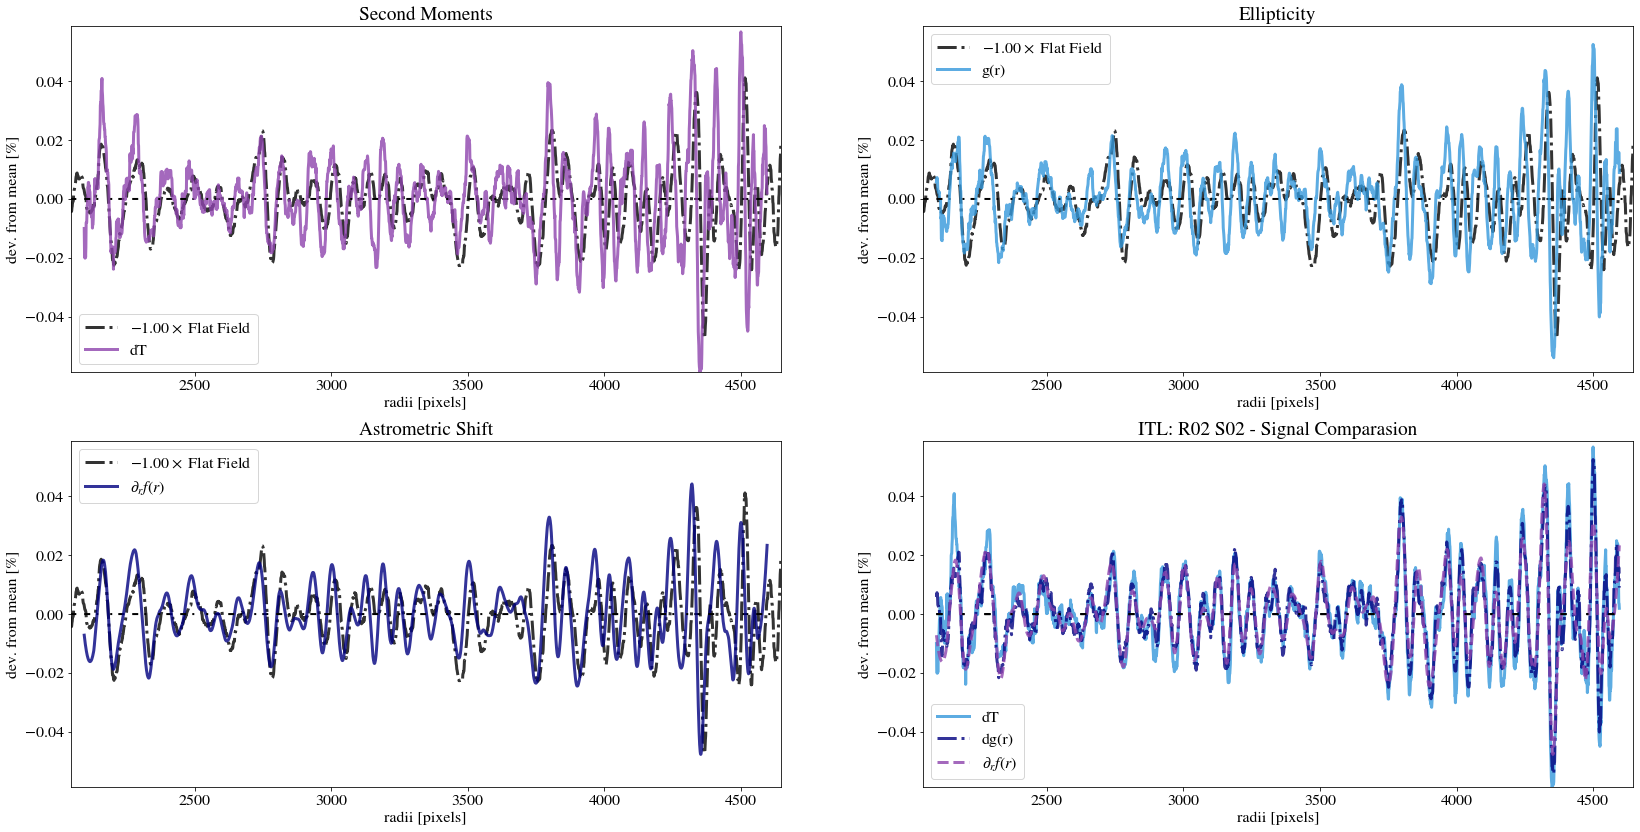

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(28, 2*6+2))

ax = axs[0,0]
factor = 1.#get_factor(dF,dT)
plot_signal(dF,label=r'$ %.2f \times $ Flat Field'%(-1*factor),
             ax=ax,factor=-1*factor,unit='%',color=colors[-1],ls='-.')
plot_signal(dT,label='dT',ax=ax,fill=False,color=colors[1])
ax.legend(fontsize=16)
ymax = 3*np.std(dT[1][1500:])
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-ymax,ymax)
ax.set_title('Second Moments')

ax = axs[0,1]
factor = 1.
plot_signal(dF,label=r'$ %.2f \times $ Flat Field'%(-1*factor),
             ax=ax,factor=-1*factor,unit='%',color=colors[-1],ls='-.')
plot_signal(dg,label='g(r)',ax=ax,fill=False,color=colors[2])
ax.legend(fontsize=16)
#ymax = 3*np.std(dg[1])
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-ymax,ymax)
ax.set_title('Ellipticity')

ax     = axs[1,0]
factor = 1.
plot_signal(dF,label=r'$%.2f \times$ %s'%(-1*factor,'Flat Field'),ax=ax,
            factor=-1*factor, fill=False,unit='%',color=colors[-1],ls='-.')
plot_signal(dr2,label='$\partial_r f(r)$',ax=ax,fill=False,color=colors[5])
#ymax = 3*np.std(dr2[1])
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-ymax,ymax)
ax.set_title('Astrometric Shift')

ax = axs[1,1]
factor = 1.#get_factor(dT,dr2,is_range=False)
plot_signal(dT,label=r'%s'%('dT'),ax=ax,factor=+1.,fill=False,unit='%',color=colors[2])
plot_signal(dg,label=r'%s'%('dg(r)') ,ax=ax,factor=+1.,fill=False,unit='%',color=colors[5],ls='-.')
plot_signal(dr2,label=r'$\partial_r f(r)$',ax=ax,fill=False,color=colors[1],ls='--')
ax.legend(fontsize=16)

#ymax = 3*np.std(dr2[1])
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-ymax,ymax)
ax.set_title(title+' - Signal Comparasion')
#fig.savefig('figures/fig_5.pdf', dpi=240, format='pdf', bbox_inches='tight')

In [108]:
np.max(dg[1][1500:])

0.052528396248817444